In [229]:
# imports

from surfacecode.logical_qubit import LQubit
from surfacecode.circuits import SquareLattice
from surfacecode.lattice import *
from surfacecode.simulators import *
from surfacecode.surface import *
from surfacecode.mwpm import ParityCheckMatrix, ErrorCorrection

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error, phase_damping_error)
from qiskit_ibm_provider import IBMProvider, least_busy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [186]:
WIDTH, HEIGHT = 3, 13
l = (7, 31)

lattice = SquareLattice(WIDTH, HEIGHT)
qubit = LQubit(lattice, l[0], l[1], True)
cycle = SurfaceCodeCycle(lattice)
num_qubits = WIDTH * HEIGHT

In [224]:
qc = ConstrainedQuantumCircuit(lattice, WIDTH * HEIGHT)
qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(num_qubits)))

qc.add_register(ClassicalRegister(num_qubits + len(qubit.route(l[0],l[1])) // 2))
qc = qc.compose(qubit.alt_initialize(cycle), list(range(num_qubits)), list(range(num_qubits, 2 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(2 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 3 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc = qc.compose(qubit.line_gate())

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(3 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

#qc.add_register(ClassicalRegister(num_qubits))
#qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(4 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 5 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(4))
qc = qc.compose(qubit.alt_measure(), list(range(num_qubits)), list(range(4 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2 + 4)))

In [206]:
qc = ConstrainedQuantumCircuit(lattice, WIDTH * HEIGHT)
qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(num_qubits)))

qc.add_register(ClassicalRegister(num_qubits + len(qubit.route(l[0],l[1])) // 2))
qc = qc.compose(qubit.alt_initialize(cycle), list(range(num_qubits)), list(range(num_qubits, 2 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(2 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 3 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc = qc.compose(qubit.circle_gate())

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(3 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(4))
qc = qc.compose(qubit.alt_measure(), list(range(num_qubits)), list(range(4 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2 + 4)))

In [231]:
noise_model = NoiseModel()
error_amplitude = amplitude_damping_error(0.1)
error_phase = phase_damping_error(0.1)
noise_model.add_all_qubit_quantum_error(error_amplitude, ['x', 'z', 'h'])
#noise_model.add_all_qubit_quantum_error(error_amplitude, ['x', 'z', 'h'])

aersim = AerSimulator(method="statevector", noise_model=noise_model)
built = transpile(qc, aersim)
job = aersim.run(built, shots=1000)
result = job.result()

TranspilerError: 'Number of qubits (39) in circuit-3381 is greater than maximum (29) in the coupling_map'

In [56]:
def parse_results(shot: str):
    a, b = int(shot[0]), int(shot[1])
    c, d = int(shot[114]), int(shot[115])
    x1 = a ^ b
    x2 = c ^ d

    return x1 ^ x2

In [57]:
results = 0
for shot in list(result.get_counts().keys()):
    results += parse_results(shot)



In [58]:
results / 1000

0.035

In [21]:
len("00 000101000100010101000100000 000101000100010101000100000 000001000100010101000100000 00010100000100000000010000011")

116

# Error correction

In [135]:
noise_model = NoiseModel()
error = depolarizing_error(0.6, 1)
noise_model.add_all_qubit_quantum_error(error, ['x', 'z', 'h'])

aersim = AerSimulator(method="stabilizer", noise_model=noise_model)
built = transpile(qc, aersim)
job = aersim.run(built, shots=100000)
result = job.result()

In [136]:
def cycles(key: str, num_stabilizers: int, width: int, height: int):
    cycles = key.split(" ")[1:]
    sep_cycles = []
    for cycle in cycles:
        cycle = cycle[:width * height]
        j = 1
        z_measures = []
        x_measures = []
        for i, measure in enumerate(cycle):
            if i >= width * j:
                j += 1
            if i % 2 == 1:
                if j % 2 == 1:
                    z_measures.append(int(measure))
                else:
                    x_measures.append(int(measure))
                    
        sep_cycle = np.concatenate([np.array(z_measures), np.array(x_measures)])
        sep_cycle = np.array(sep_cycle).reshape(1, -1)
        sep_cycles.append(sep_cycle)

    sep_cycles = np.concatenate(sep_cycles)
    return sep_cycles

In [201]:
noise_ps = np.linspace(0, 0.2, 50)
fns, fps, tns, tps = [], [], [], []

for noise_p in tqdm(noise_ps):
    noise_model = NoiseModel()
    error = depolarizing_error(noise_p, 1)
    noise_model.add_all_qubit_quantum_error(error, ['x', 'z', 'h'])

    aersim = AerSimulator(method="stabilizer", noise_model=noise_model)
    built = transpile(qc, aersim)
    job = aersim.run(built, shots = 3000)
    result = job.result()
    shots = result.get_counts()


    fn, fp, tn, tp = 0, 0, 0, 0
    counts  = result.get_counts()
    for shot in list(result.get_counts().keys()):
        count = counts[shot]
        a = cycles(shot, lattice.z_counter + lattice.x_counter, WIDTH, HEIGHT)
        parity = ParityCheckMatrix(lattice.z_counter + lattice.x_counter, len(lattice.nodes) - lattice.z_counter - lattice.x_counter)
        mm = parity._populate(lattice)
        correction = ErrorCorrection(parity)
        b = correction.analyze(np.array(list(reversed(a))[2:]))
        if b[5] ^ b[8] ^ b[11] ^ b[14]:
            a1, a2, a3, a4 = int(shot[0]), int(shot[1]), int(shot[2]), int(shot[3])
            x1 = a1 ^ a2 ^ a3 ^ a4
            b1, b2, b3, b4 = int(shot[167]), int(shot[166]), int(shot[165]), int(shot[164])
            x2 = b1 ^ b2 ^ b3 ^ b4
            x3 = x1 ^ x2
            if x3:
                fn += count
            else:
                fp += count
        else:
            a1, a2, a3, a4 = int(shot[0]), int(shot[1]), int(shot[2]), int(shot[3])
            x1 = a1 ^ a2 ^ a3 ^ a4
            b1, b2, b3, b4 = int(shot[167]), int(shot[166]), int(shot[165]), int(shot[164])
            x2 = b1 ^ b2 ^ b3 ^ b4
            x3 = x1 ^ x2
            if x3:
                tn += count
            else:
                tp += count
    
    fns.append(fn)
    fps.append(fp)
    tns.append(tn)
    tps.append(tp)

 14%|█▍        | 7/50 [00:10<01:04,  1.51s/it]


KeyboardInterrupt: 

In [225]:
noise_ps = np.linspace(0, 0.2, 50)
fns, fps, tns, tps = [], [], [], []

for noise_p in tqdm(noise_ps):
    noise_model = NoiseModel()
    error = depolarizing_error(noise_p, 1)
    noise_model.add_all_qubit_quantum_error(error, ['x', 'z', 'h'])

    aersim = AerSimulator(method="stabilizer", noise_model=noise_model)
    built = transpile(qc, aersim)
    job = aersim.run(built, shots = 5000)
    result = job.result()
    shots = result.get_counts()


    fn, fp, tn, tp = 0, 0, 0, 0

    for shot in list(shots.keys()):
        counts = shots[shot]
        a = cycles(shot, lattice.z_counter + lattice.x_counter, WIDTH, HEIGHT)
        parity = ParityCheckMatrix(lattice.z_counter + lattice.x_counter, len(lattice.nodes) - lattice.z_counter - lattice.x_counter)
        mm = parity._populate(lattice)
        correction = ErrorCorrection(parity)
        b = correction.analyze(np.array(list(reversed(a))[2:]))
        if b[5] ^ b[8] ^ b[11] ^ b[14]:
            a1, a2, a3, a4 = int(shot[0]), int(shot[1]), int(shot[2]), int(shot[3])
            x1 = a1 ^ a2 ^ a3 ^ a4
            b1, b2, b3, b4 = int(shot[127]), int(shot[126]), int(shot[125]), int(shot[124])
            x2 = b1 ^ b2 ^ b3 ^ b4
            x3 = x1 ^ x2
            if x3:
                fn += counts
            else:
                fp += counts
        else:
            a1, a2, a3, a4 = int(shot[0]), int(shot[1]), int(shot[2]), int(shot[3])
            x1 = a1 ^ a2 ^ a3 ^ a4
            b1, b2, b3, b4 = int(shot[127]), int(shot[126]), int(shot[125]), int(shot[124])
            x2 = b1 ^ b2 ^ b3 ^ b4
            x3 = x1 ^ x2
            if x3:
                tn += counts
            else:
                tp += counts

    fns.append(fn)
    fps.append(fp)
    tns.append(tn)
    tps.append(tp)



  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:55<00:00,  2.30s/it]


In [178]:
fn, fp, tn, tp

(94, 112, 342, 452)

In [179]:
(1 - ((tp + fp) / 100000)) * 100

99.436

In [180]:
(1 - ((fn + tp) / 100000)) * 100

99.454

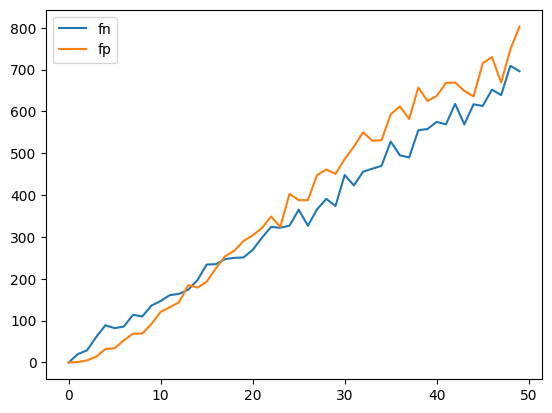

In [226]:
ids = np.arange(0, 50)

plt.plot(ids, fns, label="fn")
plt.plot(ids, fps, label="fp")
plt.legend()

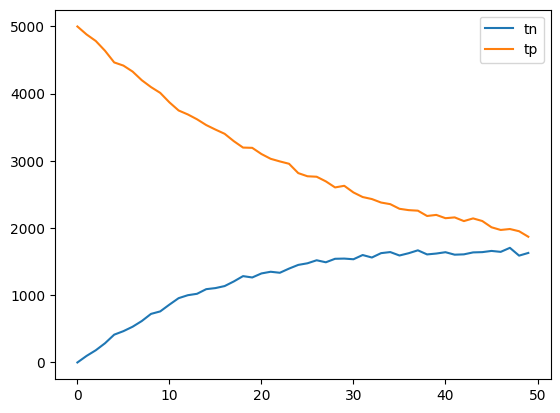

In [227]:
ids = np.arange(0, 50)

plt.plot(ids, tns, label="tn")
plt.plot(ids, tps, label="tp")
plt.legend()

In [43]:
fp + tn + tp

984

In [44]:
984 / 1000

0.984

In [100]:
def parse_results(shot: str):
    a, b = int(shot[0]), int(shot[1])
    c, d = int(shot[114]), int(shot[115])
    x1 = a ^ b
    x2 = c ^ d

    return x1 ^ x2

In [101]:
results = 0
for shot in list(counts.keys()):
    results += parse_results(shot)

In [102]:
results / 1000

1.866

In [176]:
len('1001 000001000101000101010001000101000101000 000001000101000101010001000101000001000 000001000101000101010000000001000101000 0001010000010000000001010000000000010000111')

168

In [ ]:
000001000101000101010001000101000101000
0001010000010000000001010000000000010000111

In [197]:
len('0100 000000000101010101000001000101000100000 000000000101010101000001000101000100000 0000000000000000000000010000000001000001101')

128